Loaded file appears to be a state_dict, not a complete model
Successfully loaded state_dict into ResNet50 model
Finding correctly classified healthy images...
  Found correctly classified healthy image: image_00180.png
  Found correctly classified healthy image: image_00150.png
  Found correctly classified healthy image: image_00100.png
  Found correctly classified healthy image: image_00051.png
  Found correctly classified healthy image: image_00010.png
Finding correctly classified disease images...
  Found correctly classified disease image: image_00435.png
  Found correctly classified disease image: image_00496.png
  Found correctly classified disease image: image_00437.png
  Found correctly classified disease image: image_00376.png
  Found correctly classified disease image: image_00331.png
Selected 5 correctly classified healthy images and 5 correctly classified disease images
Processing healthy images...
  Processing image_00180.png
  Processing image_00150.png
  Processing image

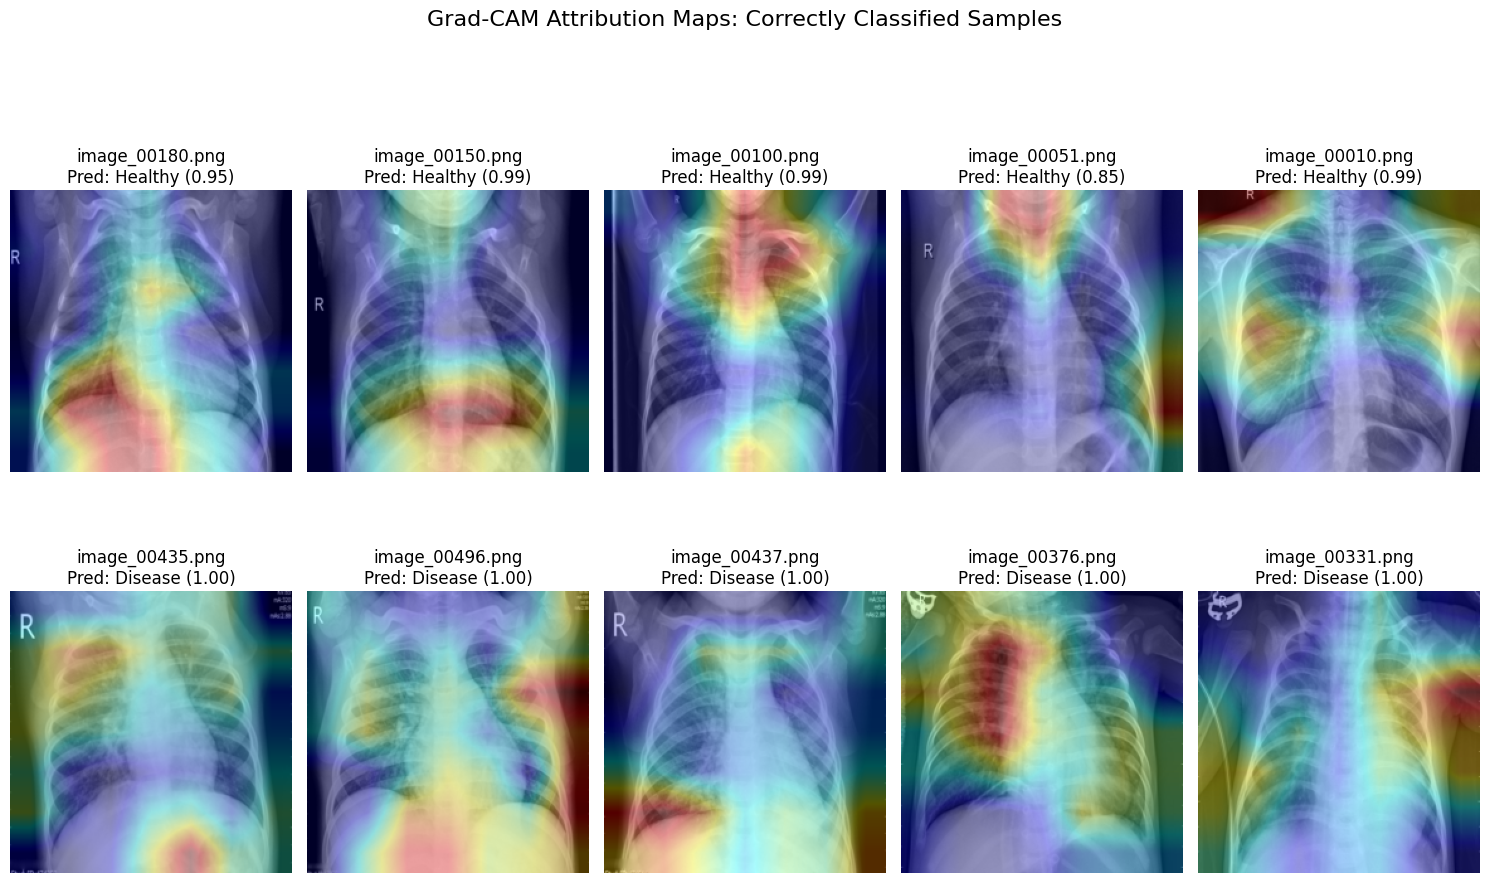

Visualization complete! Saved as 'correct_attribution_maps_comparison.png'


In [9]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
from torchvision import transforms, models
from matplotlib.gridspec import GridSpec

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_image, target_class=None):
        # Forward pass
        model_output = self.model(input_image)
        
        # Get predicted class if target not specified
        if target_class is None:
            target_class = torch.argmax(model_output)
        
        # Get model confidence scores
        confidence = F.softmax(model_output, dim=1)[0, target_class].item()
        
        # Backward pass
        self.model.zero_grad()
        one_hot_output = torch.zeros_like(model_output)
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output)
        
        # Get weights
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        
        # Weight the activations
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        
        # Apply ReLU and normalize
        cam = F.relu(cam)
        cam = cam - torch.min(cam)
        cam = cam / (torch.max(cam) + 1e-8)
        
        # Resize CAM to input image size
        cam = F.interpolate(cam, size=input_image.shape[2:], mode='bilinear', align_corners=False)
        
        return cam.squeeze().cpu().numpy(), confidence, target_class

def load_model(model_path):
    try:
        # Try loading as a complete model
        model = torch.load(model_path, map_location=torch.device('cpu'))
        
        # Check if what was loaded is actually a state_dict (OrderedDict)
        if isinstance(model, dict) or isinstance(model, torch.nn.modules.module._IncompatibleKeys) or isinstance(model, collections.OrderedDict):
            print("Loaded file appears to be a state_dict, not a complete model")
            # Initialize a model to load the state_dict into
            base_model = models.resnet50(weights=None)  # Using weights=None instead of pretrained=True
            # Modify the final layer for binary classification (assuming binary)
            num_features = base_model.fc.in_features
            base_model.fc = torch.nn.Linear(num_features, 2)  # 2 classes
            # Load the state dict
            base_model.load_state_dict(model)
            model = base_model
            print("Successfully loaded state_dict into ResNet50 model")
        else:
            print("Loaded complete model")
    except Exception as e:
        print(f"Error during initial model loading: {e}")
        try:
            # Explicitly try loading as a state_dict
            base_model = models.resnet50(weights=None)  # Using weights=None instead of pretrained=True
            num_features = base_model.fc.in_features
            base_model.fc = torch.nn.Linear(num_features, 2)  # 2 classes
            base_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
            model = base_model
            print("Loaded state_dict into ResNet50 with binary classification head")
        except Exception as e:
            print(f"Error loading state_dict: {e}")
            print("Falling back to pretrained ResNet50")
            model = models.resnet50(weights='IMAGENET1K_V1')  # Using weights parameter instead of pretrained
    
    model.eval()
    return model

def get_random_png_files(folder_path, n=5):
    """Get n random PNG files from the given folder"""
    all_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.png')]
    
    if len(all_files) < n:
        print(f"Warning: Only {len(all_files)} PNG files found in {folder_path}")
        return [os.path.join(folder_path, f) for f in all_files]
    
    selected_files = random.sample(all_files, n)
    return [os.path.join(folder_path, f) for f in selected_files]

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),  # Match your training transform
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Match your [-1,1] normalization
    ])
    
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)
    return input_tensor, image

def apply_colormap_to_cam(cam):
    cam_heatmap = np.uint8(255 * cam)
    colored_cam = cv2.applyColorMap(cam_heatmap, cv2.COLORMAP_JET)
    colored_cam = cv2.cvtColor(colored_cam, cv2.COLOR_BGR2RGB)
    return colored_cam

def visualize_folder_samples(model_path, healthy_folder, disease_folder, num_samples=5):
    # Set random seed for reproducibility
    random.seed(42)
    
    # Load model
    model = load_model(model_path)
    
    # Define target layer (for ResNet)
    if hasattr(model, 'layer4'):
        target_layer = model.layer4[-1]
    else:
        print("Please specify the correct target layer for your model")
        return
    
    # Initialize Grad-CAM
    grad_cam = GradCAM(model, target_layer)
    
    # Get all images from each folder
    all_healthy_images = get_random_png_files(healthy_folder, n=20)  # Get more than needed
    all_disease_images = get_random_png_files(disease_folder, n=20)  # Get more than needed
    
    # Filter for correctly classified images
    correctly_classified_healthy = []
    correctly_classified_disease = []
    
    # Process healthy images to find correctly classified ones
    print("Finding correctly classified healthy images...")
    for img_path in all_healthy_images:
        # Process image
        input_tensor, _ = preprocess_image(img_path)
        
        # Get prediction
        with torch.no_grad():
            output = model(input_tensor)
            pred_class = torch.argmax(output).item()
            
        # Check if correctly classified (assuming 0 = healthy)
        if pred_class == 0:
            correctly_classified_healthy.append(img_path)
            print(f"  Found correctly classified healthy image: {os.path.basename(img_path)}")
            
        # Break if we have enough samples
        if len(correctly_classified_healthy) >= num_samples:
            break
    
    # Process disease images to find correctly classified ones
    print("Finding correctly classified disease images...")
    for img_path in all_disease_images:
        # Process image
        input_tensor, _ = preprocess_image(img_path)
        
        # Get prediction
        with torch.no_grad():
            output = model(input_tensor)
            pred_class = torch.argmax(output).item()
            
        # Check if correctly classified (assuming 1 = disease)
        if pred_class == 1:
            correctly_classified_disease.append(img_path)
            print(f"  Found correctly classified disease image: {os.path.basename(img_path)}")
            
        # Break if we have enough samples
        if len(correctly_classified_disease) >= num_samples:
            break
    
    # Check if we found enough correctly classified images
    if len(correctly_classified_healthy) < num_samples:
        print(f"Warning: Only found {len(correctly_classified_healthy)} correctly classified healthy images")
    
    if len(correctly_classified_disease) < num_samples:
        print(f"Warning: Only found {len(correctly_classified_disease)} correctly classified disease images")
    
    # Use correctly classified images for visualization
    healthy_images = correctly_classified_healthy[:num_samples]
    disease_images = correctly_classified_disease[:num_samples]
    
    print(f"Selected {len(healthy_images)} correctly classified healthy images and {len(disease_images)} correctly classified disease images")
    
    # Create figure for visualization
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, min(num_samples, len(healthy_images), len(disease_images)), figure=fig)
    
    # Process healthy images
    print("Processing healthy images...")
    for i, img_path in enumerate(healthy_images):
        print(f"  Processing {os.path.basename(img_path)}")
        # Process image
        input_tensor, original_image = preprocess_image(img_path)
        original_image_np = np.array(original_image)
        
        # Generate CAM - first get prediction
        with torch.no_grad():
            output = model(input_tensor)
            pred_class = torch.argmax(output).item()
            confidence = F.softmax(output, dim=1)[0, pred_class].item()
            
        # Then generate CAM for the predicted class
        cam, _, _ = grad_cam.generate_cam(input_tensor, target_class=pred_class)
        
        # Create heatmap overlay
        heatmap = apply_colormap_to_cam(cam)
        overlay = heatmap * 0.3 + original_image_np * 0.7
        overlay = overlay / np.max(overlay)  # Normalize
        
        # Add to plot
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(overlay)
        class_name = "Healthy" if pred_class == 0 else "Disease"
        ax.set_title(f"{os.path.basename(img_path)}\nPred: {class_name} ({confidence:.2f})")
        ax.axis('off')
    
    # Process disease images
    print("Processing disease images...")
    for i, img_path in enumerate(disease_images):
        print(f"  Processing {os.path.basename(img_path)}")
        # Process image
        input_tensor, original_image = preprocess_image(img_path)
        original_image_np = np.array(original_image)
        
        # Generate CAM - first get prediction
        with torch.no_grad():
            output = model(input_tensor)
            pred_class = torch.argmax(output).item()
            confidence = F.softmax(output, dim=1)[0, pred_class].item()
            
        # Then generate CAM for the predicted class
        cam, _, _ = grad_cam.generate_cam(input_tensor, target_class=pred_class)
        
        # Create heatmap overlay
        heatmap = apply_colormap_to_cam(cam)
        overlay = heatmap * 0.3 + original_image_np * 0.7
        overlay = overlay / np.max(overlay)  # Normalize
        
        # Add to plot
        ax = fig.add_subplot(gs[1, i])
        ax.imshow(overlay)
        class_name = "Healthy" if pred_class == 0 else "Disease"
        ax.set_title(f"{os.path.basename(img_path)}\nPred: {class_name} ({confidence:.2f})")
        ax.axis('off')
    
    plt.tight_layout()
    plt.suptitle("Grad-CAM Attribution Maps: Correctly Classified Samples", fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.savefig("correct_attribution_maps_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Visualization complete! Saved as 'correct_attribution_maps_comparison.png'")

# Example usage
def main():
    model_path = "/home/taekim/ml4h_p2/resnet50_xray_neumonia.pt"  # Replace with your model path
    healthy_folder = "/home/taekim/ml4h_p2/final_preprocessed_dataset/test/NORMAL"  # Replace with path to folder containing healthy PNGs
    disease_folder = "/home/taekim/ml4h_p2/final_preprocessed_dataset/test/PNEUMONIA"  # Replace with path to folder containing disease PNGs
    
    visualize_folder_samples(model_path, healthy_folder, disease_folder, num_samples=5)

if __name__ == "__main__":
    main()